This notebook evaluates the correctness of AZKAG for our method based on biclique-graph-patterns and the classical method based on frequent-patterns. We report Recall, Precision and F-score using two types of synthetic examples for the negatives: from random sampling, and from our generation procedure. We also report some statitics about the resulting examples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from src import avpattern as avp
from efficient_apriori import apriori


### Load access control graph

In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


In [7]:
#Get attribute-values of users
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)
userlog_objs = ut.to_tuple_format(userlog_objs)

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

### Useful functions

In [8]:
def plot_bins(usrvidx_resvidx_tups):
    
    idxs_entry_events = []
    for v in gur.vs:
        if v['type']:
            idx = v.index - len(usrlabels)
            for _ in range(gur.degree(v)):
                idxs_entry_events.append(idx)
    
    
    idxs_example_events = []
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        idx = resvidx - len(usrlabels)
        idxs_example_events.append(idx)
        
    
    bins = np.linspace(0, len(reslabels), 50)
    plt.hist(idxs_entry_events,bins=bins,color='tab:blue', density=True)
    plt.hist(idxs_example_events,bins=bins,color='tab:red', alpha=0.4, density=True)
    plt.plot()
    
def cov_resources(usrvidx_resvidx_tups):
    residxsset = set()
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        residxsset.add(resvidx)
        
    return len(residxsset)/len(reslabels)

In [9]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [10]:
def next_vertex(gur, v):
    neighvidxs = gur.neighbors(v)
    i = random.randint(0,len(neighvidxs)-1)
    return gur.vs[neighvidxs[i]]
    

def get_entry_tupes(gur, max_hops, alpha, sd):
    random.seed(sd)
    usrvidx_resvidx_tups = list()
    
    for v in gur.vs:
        if v['type']: #Only resources
            neighvidxsset = set(gur.neighbors(v))
            deg = len(neighvidxsset)
            usrvidxsset = set()

            count = 0
            while len(usrvidxsset) < alpha*deg:
                v_ = v
                for i in range(max_hops):
                    v2 = next_vertex(gur, v_)
                    if i == max_hops-1 and not v2.index in neighvidxsset:
                        usrvidxsset.add(v2.index)
                    else:
                        v_ = v2
                count += 1
                
                if count > 100000:
                    break
                    
            for usrvidx in list(usrvidxsset):
                usrvidx_resvidx_tups.append((usrvidx,v.index))
        
    return usrvidx_resvidx_tups


def filter_sim(gur, usrvidx_resvidx_tups, thmin, thmax):
    usrvidx_resvidx_tups_ = []
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        cs = cosine_sim(gur, usrvidx, resvidx)
        if cs > thmin and cs <= thmax:
            usrvidx_resvidx_tups_.append(tup)
    
    return usrvidx_resvidx_tups_


def filter_atts(gur, usrvidx_resvidx_tups, minth, maxth):
    usrvidx_resvidx_tups_ = []
    
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        
        usrattvalsset = set(userlog_objs[usrvidx])
        neighattvalsset = set(resvidx_to_neighattvals[resvidx])
        
        x = len(usrattvalsset&neighattvalsset)
        if x > minth and x <= maxth:
            usrvidx_resvidx_tups_.append(tup)
            
    return usrvidx_resvidx_tups_
    

def get_non_entries(gur, numentries, sd):
    edges_tuples = []
    for e in gur.es:
        edges_tuples.append((e.source,e.target))

    usrvidxs = []
    resvidxs = []
    for v in gur.vs:
        if v['type']:
            resvidxs.append(v.index)
        else:
            usrvidxs.append(v.index)

    random.seed(sd)
    usrvidxs_random = random.choices(usrvidxs,k=10*numentries)
    resvidxs_random = random.choices(resvidxs,k=10*numentries)

    i = 0
    j = 0
    usrvidx_resvidx_tups_non = []
    while i < numentries:
        tup = (usrvidxs_random[j], resvidxs_random[j])
        if not tup in edges_tuples: 
            usrvidx_resvidx_tups_non.append(tup)
            i += 1
        j += 1
        
    return usrvidx_resvidx_tups_non


### Create positive synthetic examples

In [11]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_pos_DIST = filter_atts(gur, usrvidx_resvidx_tups, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_pos_DIST))

Num of pos examples: 20605
Covered resources: 0.4135964912280702


In [12]:
#Through SFCS method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.2, thmax=100)
usrvidx_resvidx_tups_pos_SFCS = filter_atts(gur, usrvidx_resvidx_tups_, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos_SFCS))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_pos_SFCS))

Num of pos examples: 16744
Covered resources: 0.40307017543859647


Get a subset of positive examples

In [35]:
num_pos_examples = 3200 #Because AZKAG has 32K entries (80-20)
random.seed(13)
usrvidx_resvidx_tups_pos_DIST_sam = random.sample(usrvidx_resvidx_tups_pos_DIST,num_pos_examples)
random.seed(13)
usrvidx_resvidx_tups_pos_SFCS_sam = random.sample(usrvidx_resvidx_tups_pos_SFCS,num_pos_examples)

Plot some distributions

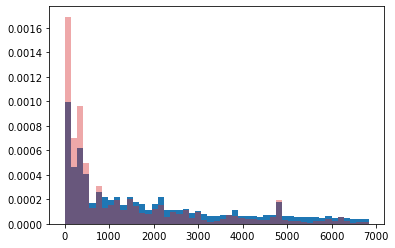

In [36]:
plot_bins(usrvidx_resvidx_tups_pos_SFCS_sam)

### Create negative synthetic examples

In [15]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_neg_DIST = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_DIST))

Num of neg examples: 27906
Covered resources: 0.8236842105263158


In [16]:
#Through SFCS method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.05, thmax=0.2)
usrvidx_resvidx_tups_neg_SFCS = filter_atts(gur, usrvidx_resvidx_tups_, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_SFCS))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_SFCS))

Num of neg examples: 5106
Covered resources: 0.20833333333333334


In [17]:
#Through RANDOM method
usrvidx_resvidx_tups = get_non_entries(gur, numentries=20000, sd=13)
usrvidx_resvidx_tups_neg_RANDOM = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_RANDOM))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_RANDOM))

Num of neg examples: 4575
Covered resources: 0.4570175438596491


Get subset of negative examples

In [37]:
num_neg_examples = 3200 #Because AZKAG has 32K entries (80-20)
random.seed(13)
usrvidx_resvidx_tups_neg_DIST_sam = random.sample(usrvidx_resvidx_tups_neg_DIST,num_neg_examples)
random.seed(13)
usrvidx_resvidx_tups_neg_SFCS_sam = random.sample(usrvidx_resvidx_tups_neg_SFCS,num_neg_examples)
random.seed(13)
usrvidx_resvidx_tups_neg_RANDOM_sam = random.sample(usrvidx_resvidx_tups_neg_RANDOM,num_neg_examples)

Plot some distributions

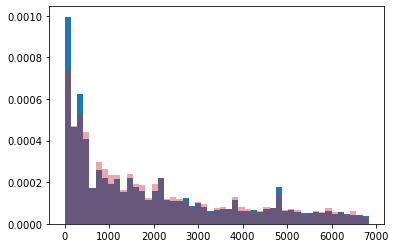

In [38]:
plot_bins(usrvidx_resvidx_tups_neg_DIST_sam)

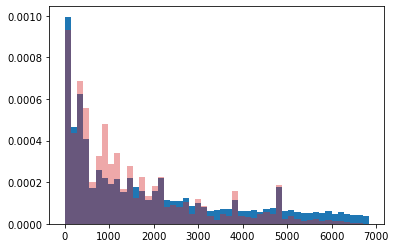

In [39]:
plot_bins(usrvidx_resvidx_tups_neg_SFCS_sam)

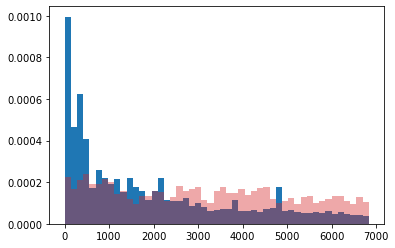

In [40]:
plot_bins(usrvidx_resvidx_tups_neg_RANDOM_sam)

In [22]:
def print_measures(num_pos, num_neg, num_truepos, num_falsepos):
    print('TPR (Recall):', num_truepos/num_pos)
    #print('FPR', num_falsepos/num_neg)
    recall = num_truepos/num_pos
    precision = num_truepos/(num_truepos+num_falsepos)
    fscore = 2*recall*precision/(recall+precision)
    print('Precision:', precision)
    print('Fscore:', fscore)
    
    num_trueneg = num_neg - num_falsepos
    acc = (num_truepos+num_trueneg)/(num_pos+num_neg)
    print('Accuracy:', acc)

### Evaluate biclique graph patterns

In [23]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('Total bicliques:', len(bcs))

Total bicliques: 17563


In [24]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 1:
        nusr = len(bc.get_usrids())
        nres = len(bc.get_resids())
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 12263


In [25]:
with open('data_structures/azkag_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

In [26]:
bcid_to_bc = {bc.get_id():bc for bc in subbcs}
gps = bcg.dfs(bcgraph, bcid_to_bc, sa=1)
print('Num graph patterns:', len(gps))

Num graph patterns: 6886


In [27]:
gps_final = []
for gpidx,gp in enumerate(gps):
    if len(gp[1]) < 50:
        gps_final.append(gp)

gps_final = [gp for gp in gps_final if len(gp[0])>1]

In [28]:
len(gps_final)

6375

In [29]:
#Create mappings
rules = [gp[0] for gp in gps_final]

bcid_to_ruleidxs = dict()
for ruleidx,gp in enumerate(gps_final):
    for bcid in gp[1]:
        if not bcid in bcid_to_ruleidxs:
            bcid_to_ruleidxs[bcid] = []
        bcid_to_ruleidxs[bcid].append(ruleidx)
        
#Agregado debido que ahora cargo el grafo de respaldo
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx
    
resid_to_bcids = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    resids_ = bc.get_resids()
    for resid in resids_:
        if not resid in resid_to_bcids:
            resid_to_bcids[resid] = []
        resid_to_bcids[resid].append(bcid) 

In [30]:
def evaluate_bgp(gur, usrvidx_resvidx_tups):

    num_valid = 0
    num_trues = 0

    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if resid in resid_to_bcids:
            ruleidxs = set()
            for bcid in resid_to_bcids[resid]:
                if bcid in bcid_to_ruleidxs:
                    ruleidxs |= set(bcid_to_ruleidxs[bcid])

            ruleidxs = list(ruleidxs)

            if len(ruleidxs) > 0:
                num_valid += 1

            for ruleidx in ruleidxs:
                rule = rules[ruleidx]
                if len(set(usrattvals)&set(rule)) == len(rule):
                        num_trues += 1
                        break
                        
    return num_valid, num_trues
            


In [41]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_DIST_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.8709375
Precision: 0.7949229891614376
Fscore: 0.8311959439308083
Accuracy: 0.823125


In [42]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.8709375
Precision: 0.9095953002610966
Fscore: 0.8898467432950192
Accuracy: 0.8921875


In [43]:
#Pos: sfcs, Neg: sfcs
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_SFCS_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.875625
Precision: 0.8072601555747623
Fscore: 0.8400539649228003
Accuracy: 0.83328125


In [44]:
#Pos: sfcs, Neg: random
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.875625
Precision: 0.9100357258850276
Fscore: 0.8924988055422838
Accuracy: 0.89453125


### Evaluation frequent patterns

In [47]:
def evaluate_fp(gur, usrvidx_resvidx_tups, resid_to_patterns):
    num_valid = 0
    num_trues = 0
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if len(resid_to_patterns[resid]) > 0:
            num_valid += 1

        for rule in resid_to_patterns[resid]:
            if len(set(usrattvals)&set(rule)) == len(rule):
                    num_trues += 1
                    break
                    
    return num_valid, num_trues
    

In [48]:
global_f = 10
resid_to_valsentries_10,resid_to_patterns_10=\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [49]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_DIST_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.4084375
Precision: 0.9051246537396122
Fscore: 0.5628768303186907
Accuracy: 0.6828125


In [50]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.4084375
Precision: 0.9886535552193646
Fscore: 0.578062804068996
Accuracy: 0.701875


In [51]:
#Pos: sfcs, Neg: sfcs
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_SFCS_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.405
Precision: 0.8950276243093923
Fscore: 0.557659208261618
Accuracy: 0.67875


In [52]:
#Pos: sfcs, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.405
Precision: 0.988558352402746
Fscore: 0.5745954333850587
Accuracy: 0.70015625


In [53]:
global_f = 5
resid_to_valsentries_05,resid_to_patterns_05=\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [54]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_05)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_DIST_sam, resid_to_patterns_05)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.595
Precision: 0.8631006346328196
Fscore: 0.7044025157232705
Accuracy: 0.7503125


In [55]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_05)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_05)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.595
Precision: 0.9764102564102564
Fscore: 0.7394174757281553
Accuracy: 0.7903125


In [56]:
#Pos: sfcs, Neg: sfcs
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam, resid_to_patterns_05)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_SFCS_sam, resid_to_patterns_05)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.6
Precision: 0.8656447249774571
Fscore: 0.70874861572536
Accuracy: 0.7534375


In [57]:
#Pos: sfcs, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam, resid_to_patterns_05)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_05)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.6
Precision: 0.9766022380467956
Fscore: 0.743321718931475
Accuracy: 0.7928125
